<a href='https://colab.research.google.com/github/tweks/sae-sd/blob/main/clip_embeddings_analysis.ipynb' target='_parent'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/></a>

# Setup

In [12]:
try:
    import google.colab
    !pip install datasets diffusers accelerate transformers
except:
    pass

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
from datasets import load_dataset
from tqdm.notebook import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
import matplotlib.pyplot as plt

# Dataset

In [14]:
subset_size = 10000
full_dataset = load_dataset('pixparse/cc3m-wds', split='train', data_files='cc3m-train-000*.tar').shuffle(seed=42)['txt']
print(f'Downloaded {len(full_dataset)} examples.')  # 50460

Downloaded 50460 examples.


In [15]:
dataset = full_dataset[:subset_size]
train_data = full_dataset[subset_size:2*subset_size]

In [16]:
dataset[:10]

['hard rock artist performs on stage during festival .',
 'the bride and groom are hoisted into the air by excited guests at the wedding reception .',
 'right move ? the estate agents admit that',
 'a closeup still life of a toy on a red background',
 'an interior view of the new super hospital .',
 'the boxy cabin was constructed in a forest outside a city .',
 'young handsome man riding a vintage bicycle outdoor .',
 'an exterior view of 33rd street during fashion week',
 'muslim woman in veil ready to shoot an arrow at desert',
 'person attends premiere during festival at festivals']

In [17]:
model_id = 'openai/clip-vit-large-patch14'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = CLIPTokenizer.from_pretrained(model_id)
text_encoder = CLIPTextModel.from_pretrained(model_id)
text_encoder = text_encoder.to(device)
text_encoder.eval()

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

# Helper functions

In [18]:
num_tokens = 77

In [19]:
def compute_batch_embeddings(text_list):
    """Helper to tokenize and encode a batch of text, returning last_hidden_state."""
    tokens = tokenizer(
        text_list,
        padding='max_length',
        truncation=True,
        max_length=num_tokens,
        return_tensors='pt'
    )
    tokens = {k: v.to(device) for k, v in tokens.items()}
    with torch.no_grad():
        outputs = text_encoder(**tokens)
    # outputs.last_hidden_state -> shape: (batch_size, 77, hidden_dim)
    return outputs.last_hidden_state

In [40]:
def compute_embeddings(data, batch_size=32):
    embs = []
    for start_idx in tqdm(range(0, subset_size, batch_size)):
        end_idx = min(start_idx + batch_size, subset_size)
        batch_captions = data[start_idx:end_idx]

        # Encode batch
        batch_emb = compute_batch_embeddings(batch_captions)  # (B, 77, hidden_dim)
        embs.append(batch_emb)
    return torch.cat(embs, dim=0)

In [39]:
def compute_metrics(dataset, batch_size=32):
    cos_sim_matrix = torch.zeros(num_tokens, num_tokens, dtype=torch.float32).to(device)
    l2_matrix = torch.zeros(num_tokens, num_tokens, dtype=torch.float32).to(device)
    num_samples = 0
    dataset_size = dataset.size(0)
    for start_idx in tqdm(range(0, dataset_size, batch_size)):
        end_idx = min(start_idx + batch_size, dataset_size)
        batch_emb = dataset[start_idx:end_idx]

        # Get batch sizes
        bsize, _, _ = batch_emb.shape

        # For each sample in the batch:
        #   1) get the [77, emb_dim] embeddings
        #   2) compute 77 x 77 cos sim
        #   3) compute 77 x 77 L2 distances
        #   4) accumulate
        # We'll do this in a vectorized manner.

        # Normalize for cosine similarity
        # shape: (B, 77, 1)
        normed = F.normalize(batch_emb, p=2, dim=-1)  # shape: (B, 77, emb_dim)
        # Cosine similarity per sample: (B, 77, 77)
        cos_sims = torch.bmm(normed, normed.transpose(1, 2))

        # L2 distances per sample using cdist for each in the batch
        # (though cdist won't vectorize across B easily)
        # We'll do a loop or stack:
        l2s = []
        for i in range(bsize):
            # shape: (77, 77)
            dists = torch.cdist(batch_emb[i], batch_emb[i], p=2)
            l2s.append(dists)
        l2s = torch.stack(l2s, dim=0)  # (B, 77, 77)

        # Accumulate
        cos_sim_matrix += cos_sims.sum(dim=0)
        l2_matrix += l2s.sum(dim=0)
        num_samples += bsize

    # Average over the total number of samples
    cos_sim_matrix /= num_samples
    l2_matrix /= num_samples
    return cos_sim_matrix, l2_matrix

In [33]:
def plot_cos_sim(cos_sim_matrix):
    matrix = cos_sim_matrix.cpu().numpy()
    plt.imshow(matrix, origin='lower')
    plt.colorbar()
    plt.title('Average Cosine Similarity (Token vs. Token)')
    plt.xlabel('Token index')
    plt.ylabel('Token index')
    plt.show()

In [34]:
def plot_l2(l2_matrix):
    matrix = l2_matrix.cpu().numpy()
    plt.imshow(matrix, origin='lower')
    plt.colorbar()
    plt.title('Average L2 Distance (Token vs. Token)')
    plt.xlabel('Token index')
    plt.ylabel('Token index')
    plt.show()

# Embedding analysis

In [41]:
dataset_embs = compute_embeddings(dataset)

  0%|          | 0/313 [00:00<?, ?it/s]

In [42]:
cos_sim_matrix, l2_matrix = compute_metrics(dataset_embs)

  0%|          | 0/313 [00:00<?, ?it/s]

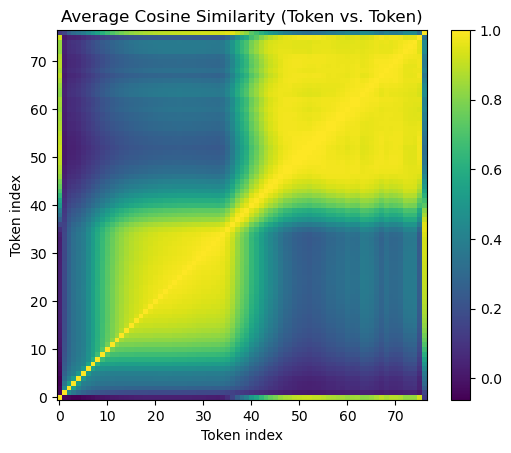

In [43]:
plot_cos_sim(cos_sim_matrix)

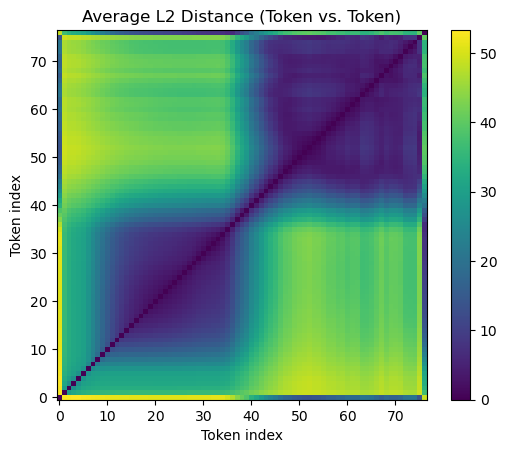

In [44]:
plot_l2(l2_matrix)

# Tuned Lens

In [30]:
class TunedLens(nn.Module):
    def __init__(self, num_tokens=77, emb_dim=768):
        super().__init__()
        lens = nn.Linear(emb_dim, emb_dim, bias=True)
        lens.weight.data.zero_()
        lens.bias.data.zero_()
        self.lenses = nn.ModuleList([deepcopy(lens) for _ in range(num_tokens-1)])

    def forward(self, x):
        # Token embedding at position 0 acts as the target.
        target = x[:, 0, :]  # shape: (batch_size, emb_dim)
        transformed_tokens = [target]
        for i, lens in enumerate(self.lenses, start=1):
            token = x[:, i, :]
            transformed = token + lens(token)  # shape: (batch_size, emb_dim)
            transformed_tokens.append(transformed)
        
        # Stack along a new dimension to create a tensor of shape (batch_size, 76, emb_dim)
        return torch.stack(transformed_tokens, dim=1)

In [ ]:
# Training dataset
train_ds = compute_embeddings(train_data)

In [24]:
train_ds.shape

torch.Size([10000, 77, 768])

In [28]:
def train(model, train_ds, num_epochs=10, batch_size=32, lr=1e-3):
    model.train()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    n = train_ds.size(0)
    for epoch in tqdm(range(num_epochs), desc='Epoch'):
        total_loss = 0.0
        # Shuffle indices each epoch
        indices = torch.randperm(n)
        for i in tqdm(range(0, n, batch_size), desc='Batch'):
            batch_indices = indices[i:i+batch_size]
            batch = train_ds[batch_indices]  # shape: (batch_size, 77, emb_dim)

            optimizer.zero_grad()
            # Forward pass: output shape is (batch_size, 77, emb_dim)
            output = model(batch)
            # Extract target token (position 0)
            target = output[:, 0, :]  # shape: (batch_size, emb_dim)
            # Transformed tokens from positions 1..76
            prediction = output[:, 1:, :]  # shape: (batch_size, 76, emb_dim)
            # Expand target along the sequence dimension to match prediction shape
            target_expanded = target.unsqueeze(1).expand_as(prediction)

            loss = loss_fn(prediction, target_expanded)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch.size(0)
        
        avg_loss = total_loss / n
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [31]:
model = TunedLens(num_tokens=77, emb_dim=768)
train(model, train_ds, num_epochs=10, batch_size=32, lr=1e-3)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.5717
Epoch 2/10, Loss: 0.1445
Epoch 3/10, Loss: 0.0865
Epoch 4/10, Loss: 0.0540
Epoch 5/10, Loss: 0.0344
Epoch 6/10, Loss: 0.0227
Epoch 7/10, Loss: 0.0158
Epoch 8/10, Loss: 0.0118
Epoch 9/10, Loss: 0.0093
Epoch 10/10, Loss: 0.0077


In [46]:
model.eval()
with torch.no_grad():
    transformed_embs = model(dataset_embs)

In [47]:
tl_cos_sim_matrix, tl_l2_matrix = compute_metrics(transformed_embs)

  0%|          | 0/313 [00:00<?, ?it/s]

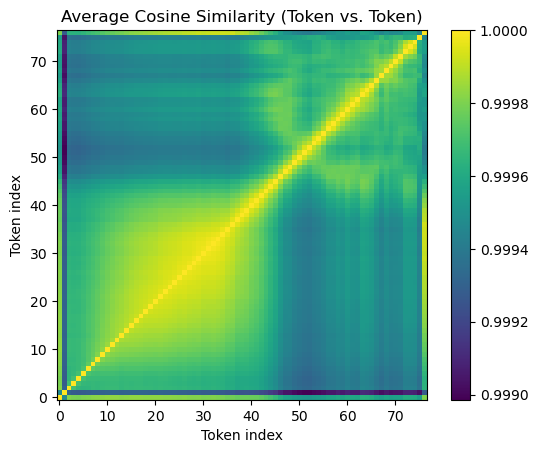

In [48]:
plot_cos_sim(tl_cos_sim_matrix)

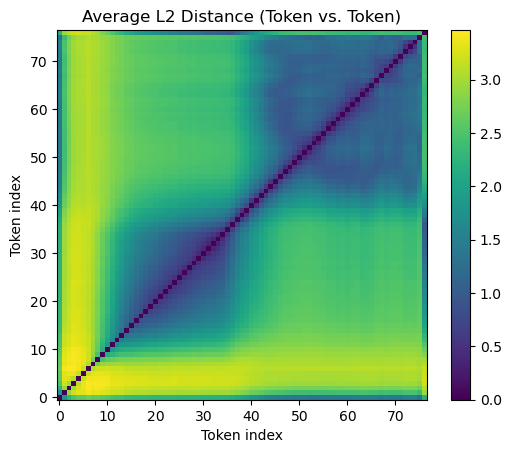

In [49]:
plot_l2(tl_l2_matrix)

# Appendix

In [22]:
dataset_lenghts = [len(tokenizer.encode(s)) for s in dataset['txt']]
max(dataset_lenghts)

47

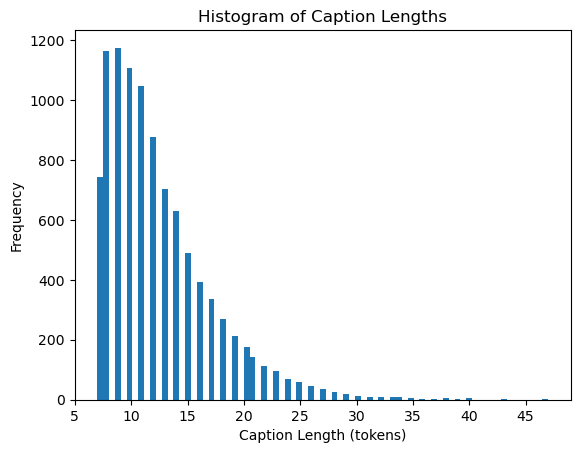

In [23]:
plt.hist(dataset_lenghts, bins=77)
plt.xlabel('Caption Length (tokens)')
plt.ylabel('Frequency')
plt.title('Histogram of Caption Lengths')
plt.show()

In [24]:
caption = dataset['txt'][0]
tokens = tokenizer.encode(caption)
tokens

[49406,
 29072,
 7564,
 953,
 320,
 18664,
 3042,
 1601,
 2054,
 1027,
 1590,
 518,
 874,
 6632,
 539,
 518,
 1063,
 269,
 49407]

In [25]:
tokenizer.convert_ids_to_tokens(tokens)

['<|startoftext|>',
 'cheerleader</w>',
 'celebrates</w>',
 'after</w>',
 'a</w>',
 'touchdown</w>',
 'catch</w>',
 'against</w>',
 'sports</w>',
 'team</w>',
 'during</w>',
 'the</w>',
 'first</w>',
 'quarter</w>',
 'of</w>',
 'the</w>',
 'game</w>',
 '.</w>',
 '<|endoftext|>']

In [26]:
torch.set_printoptions(threshold=700)
for i, row in enumerate(embeddings[0]):
    print(i, row)
torch.set_printoptions(profile='default')

0 tensor([-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675])
1 tensor([-0.7054, -0.6431,  1.4698,  ..., -0.2328,  1.4433,  1.5253])
2 tensor([-0.0691, -2.0457,  1.1803,  ..., -0.3225,  0.3826,  0.5364])
3 tensor([-1.0096, -0.5693,  1.0233,  ...,  0.3792,  0.7902, -0.2150])
4 tensor([-0.2939, -1.1924,  1.3330,  ..., -0.0144, -0.1725,  0.8676])
5 tensor([-0.2824, -0.7433,  1.8958,  ..., -0.3629,  0.0809, -0.8304])
6 tensor([ 0.1000, -1.0624,  1.3841,  ..., -1.0866, -0.4740, -0.5819])
7 tensor([ 0.4653,  0.0349,  1.9089,  ..., -0.3492, -0.1034, -0.1424])
8 tensor([ 0.0464, -1.5397,  1.2917,  ..., -1.5274, -0.0328, -0.3574])
9 tensor([ 0.4038, -0.8301,  1.2747,  ..., -0.5870, -0.0613,  0.3023])
10 tensor([0.0737, 0.4506, 1.2574,  ..., 0.3662, 0.1933, 0.7774])
11 tensor([ 0.3291, -0.0721,  1.6198,  ...,  0.6006,  0.0651,  0.2659])
12 tensor([-1.0831, -0.3760,  2.0515,  ...,  0.8222,  0.2066, -0.7384])
13 tensor([ 1.0165, -2.2182,  1.6131,  ...,  0.1790,  0.1408,  0.2862])
14 tenso